## Introduction

Can you improve lung cancer detection?
So we are working on lung cancer detection with this dataset

Working with these files can be a challenge, especially given their heterogeneous nature. Some preprocessing is required before they are ready for consumption by your CNN.


**This notebook aims to provide a comprehensive overview of useful steps to take before the data hits your ConvNet/other ML method.**

What we will cover:  

* **Loading the DICOM files**, and adding missing metadata  
* **Converting the pixel values to *Hounsfield Units (HU)***, and what tissue these unit values correspond to
* **Resampling** to an isomorphic resolution to remove variance in scanner resolution.
* **3D plotting**, visualization is very useful to see what we are doing.
* **Lung segmentation**
* **Normalization** that makes sense.
* **Zero centering** the scans.

In [20]:
%matplotlib inline
!pip install pydicom


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
# Constants
INPUT_FOLDER = '/kaggle/input/luna16/subset0'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

# Loading the files
Dicom is the file standard in medical imaging. 
These files contain a lot of metadata (such as the pixel size, so how long one pixel is in every dimension in the real world). 

This pixel size/coarseness of the scan differs from scan to scan (e.g. the distance between slices may differ), which can hurt performance of CNN approaches. We can deal with this by isomorphic resampling, which we will do later.

Below is code to load a scan, which consists of multiple slices, which we simply save in a Python list. Every folder in the dataset is one scan (so one patient). One metadata field is missing, the pixel size in the Z direction, which is the slice thickness. Fortunately we can infer this, and we add this to the metadata.

In [27]:
def load_scan(mhd_path):
    """
    Load a CT scan from a .mhd file and its corresponding .raw file.
    """
    # Read the .mhd file using SimpleITK
    itk_img = sitk.ReadImage(mhd_path)
    
    # Convert the image to a numpy array
    scan_array = sitk.GetArrayFromImage(itk_img)  # Shape: [z, y, x]
    
    # Get the origin and spacing
    origin = np.array(itk_img.GetOrigin())       # Coordinates of the origin
    spacing = np.array(itk_img.GetSpacing())     # Spacing between pixels
    
    return scan_array, origin, spacing

The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

  [1]: http://i.imgur.com/4rlyReh.png

In [28]:
def get_pixels_hu(scan_array, intercept=-1024):
    """
    Convert the scan array to Hounsfield Units (HU).
    """
    # Convert to int16
    image = scan_array.astype(np.int16)
    
    # Set outside-of-scan pixels to 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield Units (HU)
    image += intercept
    
    return image

Let's take a look at one of the patients.

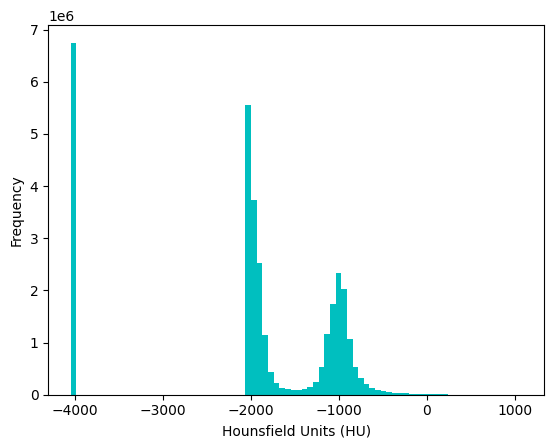

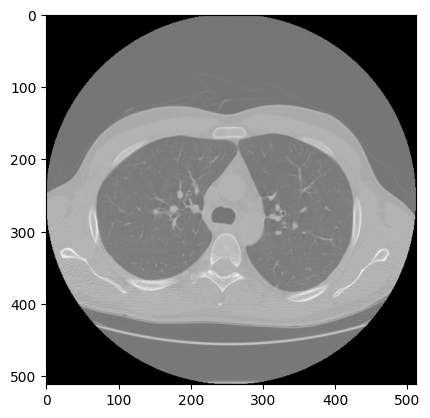

In [30]:
# Example usage
mhd_file = os.path.join(INPUT_FOLDER, 'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')
scan_array, origin, spacing = load_scan(mhd_file)
scan_pixels = get_pixels_hu(scan_array)

# Plot histogram of pixel intensities
plt.hist(scan_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show a slice in the middle
plt.imshow(scan_pixels[80], cmap=plt.cm.gray)
plt.show()

Looking at the table from Wikipedia and this histogram, we can clearly see which pixels are air and which are tissue. We will use this for lung segmentation in a bit :)


----------

# Resampling
A scan may have a pixel spacing of `[2.5, 0.5, 0.5]`, which means that the distance between slices is `2.5` millimeters. For a different scan this may be `[1.5, 0.725, 0.725]`, this can be problematic for automatic analysis (e.g. using ConvNets)! 

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm*1mm*1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.

Below code worked well for us (and deals with the edge cases):

In [38]:
# Load the scan
mhd_file = os.path.join(INPUT_FOLDER, 'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')
scan_array, origin, spacing = load_scan(mhd_file)
# Convert to Hounsfield Units (HU)
first_patient_pixels = get_pixels_hu(scan_array)
# Assuming first_patient_pixels is your NumPy array
first_patient_pixels = np.array(scan_array)  # Replace with your actual data

# Convert the NumPy array to a SimpleITK Image
image = sitk.GetImageFromArray(first_patient_pixels)
image.SetSpacing([1, 1, 1])  # Set the original spacing

# Define the resample function
def resample(image, new_spacing=[1, 1, 1]):
    """
    Resample the input image to the specified new spacing.
    
    Parameters:
    - image: The input SimpleITK image to be resampled.
    - new_spacing: The desired output spacing (default is [1, 1, 1]).
    
    Returns:
    - resampled_image: The resampled SimpleITK image.
    - new_spacing: The new spacing used for resampling.
    """
    # Get the original spacing from the image
    original_spacing = np.array(image.GetSpacing(), dtype=np.float32)
    
    # Calculate the resize factor
    resize_factor = original_spacing / new_spacing
    
    # Compute the new size
    new_size = np.round(np.array(image.GetSize()) * resize_factor)
    new_size = new_size.astype(int)
    
    # Create the resample filter
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetSize(new_size.tolist())
    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetOutputOrigin(image.GetOrigin())
    resample_filter.SetOutputDirection(image.GetDirection())
    resample_filter.SetDefaultPixelValue(image.GetPixelIDValue())
    resample_filter.SetInterpolator(sitk.sitkLinear)  # Use linear interpolation
    
    # Perform the resampling
    resampled_image = resample_filter.Execute(image)
    
    return resampled_image, new_spacing

Please note that when you apply this, to save the new spacing! Due to rounding this may be slightly off from the desired spacing (above script picks the best possible spacing with rounding).

Let's resample our patient's pixels to an isomorphic resolution of 1 by 1 by 1 mm.

In [39]:
# Resample the image
resampled_image, new_spacing = resample(image, new_spacing=[1, 1, 1])

# Convert the resampled image back to a NumPy array
resampled_pixels = sitk.GetArrayFromImage(resampled_image)

print("Shape before resampling:", first_patient_pixels.shape)
print("Shape after resampling:", resampled_pixels.shape)

Shape before resampling: (121, 512, 512)
Shape after resampling: (121, 512, 512)


# 3D plotting the scan
For visualization it is useful to be able to show a 3D image of the scan. Unfortunately, the packages available in this Kaggle docker image is very limited in this sense, so we will use marching cubes to create an approximate mesh for our 3D object, and plot this with matplotlib. Quite slow and ugly, but the best we can do.

In [40]:

def plot_3d(image, threshold=-300):
    """
    Visualize a 3D medical image using surface extraction and plotting.
    
    Parameters:
    - image: 3D numpy array representing the medical image.
    - threshold: Intensity threshold for surface extraction (default is -300).
    """
    # Ensure the image is in the correct orientation
    p = image.transpose(2, 1, 0)  # Adjust this if necessary

    # Perform surface extraction using marching cubes
    verts, faces, _, _ = measure.marching_cubes(p, level=threshold)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a mesh from the vertices and faces
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    mesh.set_facecolor([0.45, 0.45, 0.75])  # Set face color
    ax.add_collection3d(mesh)

    # Set plot limits
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    # Display the plot
    plt.show()

Our plot function takes a threshold argument which we can use to plot certain structures, such as all tissue or only the bones. 400 is a good threshold for showing the bones only (see Hounsfield unit table above). Let's do this!

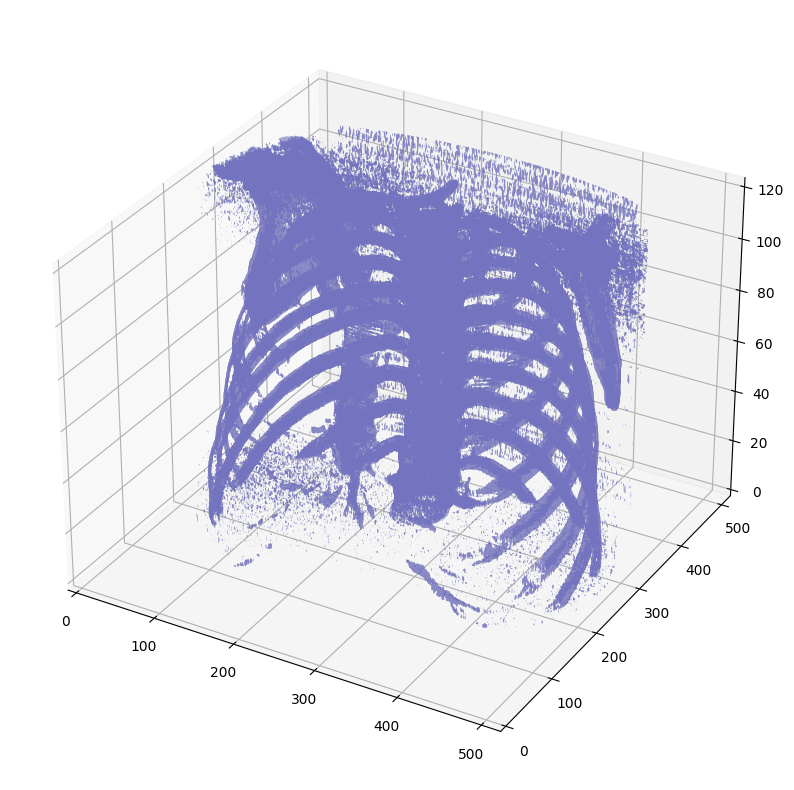

In [ ]:
# Assuming 'pix_resampled' is your 3D image array
threshold_value = 400  # Set your desired threshold

# Call the plot_3d function with the specified threshold
plot_3d(resampled_pixels, threshold=threshold_value)

Spooky!

# Lung segmentation
In order to reduce the problem space, we can segment the lungs (and usually some tissue around it). The method that me and my student colleagues developed was quite effective. 

It involves quite a few smart steps. It consists of a series of applications of region growing and morphological operations. In this case, we will use only connected component analysis.

The steps:  

* Threshold the image (-320 HU is a good threshold, but it doesn't matter much for this approach)
* Do connected components, determine label of air around person, fill this with 1s in the binary image
* Optionally: For every axial slice in the scan, determine the largest solid connected component (the body+air around the person), and set others to 0. This fills the structures in the lungs in the mask.
* Keep only the largest air pocket (the human body has other pockets of air here and there).

In [43]:
def largest_label_volume(im, bg=-1):
    """
    Finds the label with the largest volume in the image, ignoring the background.
    """
    vals, counts = np.unique(im, return_counts=True)
    # Remove the background label from the counts and values.
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    """
    Segment the lung from a 3D CT scan.
    
    Parameters:
    - image: 3D NumPy array (e.g., resampled_pixels) representing the CT scan.
    - fill_lung_structures: If True, fill in the lung structures (useful to remove vessels).
    
    Returns:
    - binary_image: 3D NumPy array where lungs are 1 and everything else is 0.
    """
    # Threshold the image. Values > -320 are set to 1 (inside), then add 1 so background is 1 and lung is 2.
    binary_image = np.array(image > -320, dtype=np.int8) + 1
    
    # Label the image.
    labels = measure.label(binary_image)
    
    # Pick the label from a corner as background (air around the patient).
    background_label = labels[0, 0, 0]
    
    # Fill the air around the person.
    binary_image[labels == background_label] = 2
    
    if fill_lung_structures:
        # Loop through each axial slice and keep only the largest solid structure.
        for i, axial_slice in enumerate(binary_image):
            # Subtract 1 to get a proper binary image.
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            if l_max is not None:  # This slice contains lung tissue.
                binary_image[i][labeling != l_max] = 1
    
    # Make the image binary.
    binary_image -= 1
    binary_image = 1 - binary_image  # Invert: lungs become 1.
    
    # Remove any remaining air pockets inside the body.
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None:
        binary_image[labels != l_max] = 0
 
    return binary_image

In [44]:
# Segment the lungs from the resampled image.
segmented_lungs = segment_lung_mask(resampled_pixels, fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(resampled_pixels, fill_lung_structures=True)

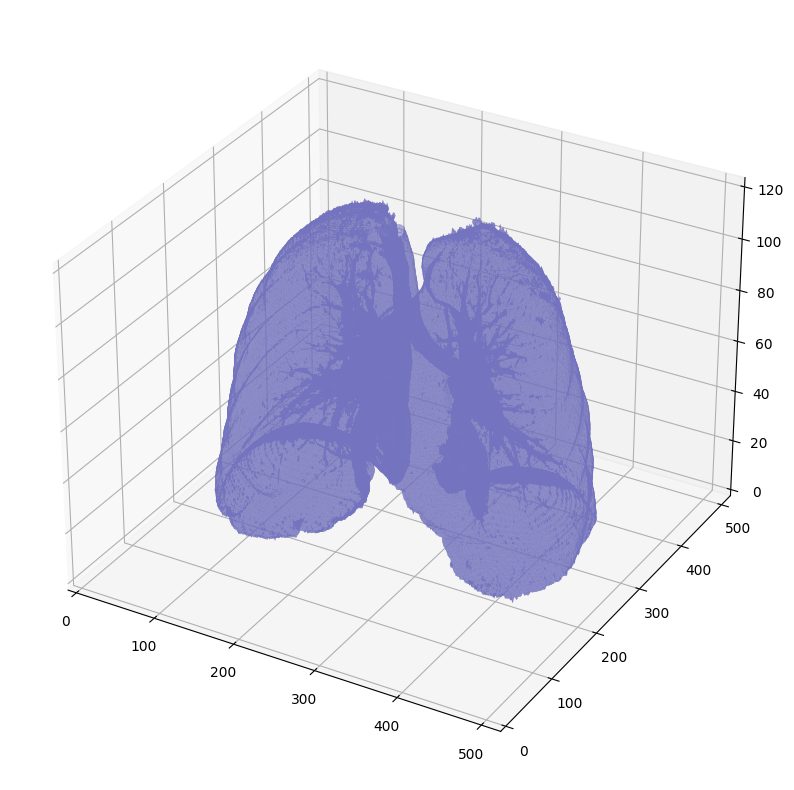

In [46]:
plot_3d(segmented_lungs, threshold=0)

Beautiful! 

But there's one thing we can fix, it is probably a good idea to include structures within the lung (as the nodules are solid), we do not only want to air in the lungs. 

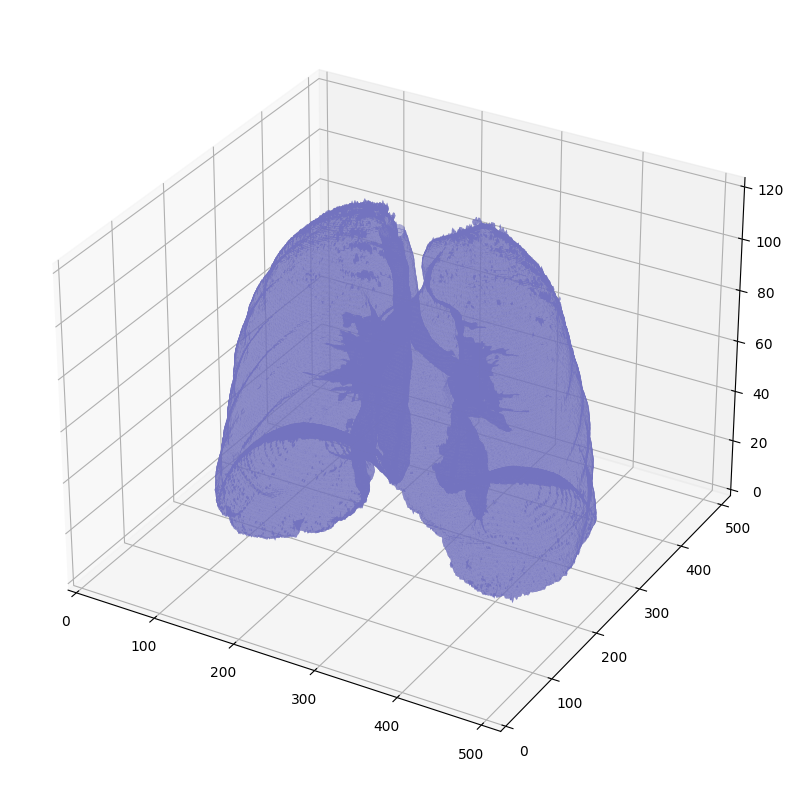

In [47]:
plot_3d(segmented_lungs_fill, threshold=0)

That's better. Let's also visualize the difference between the two.

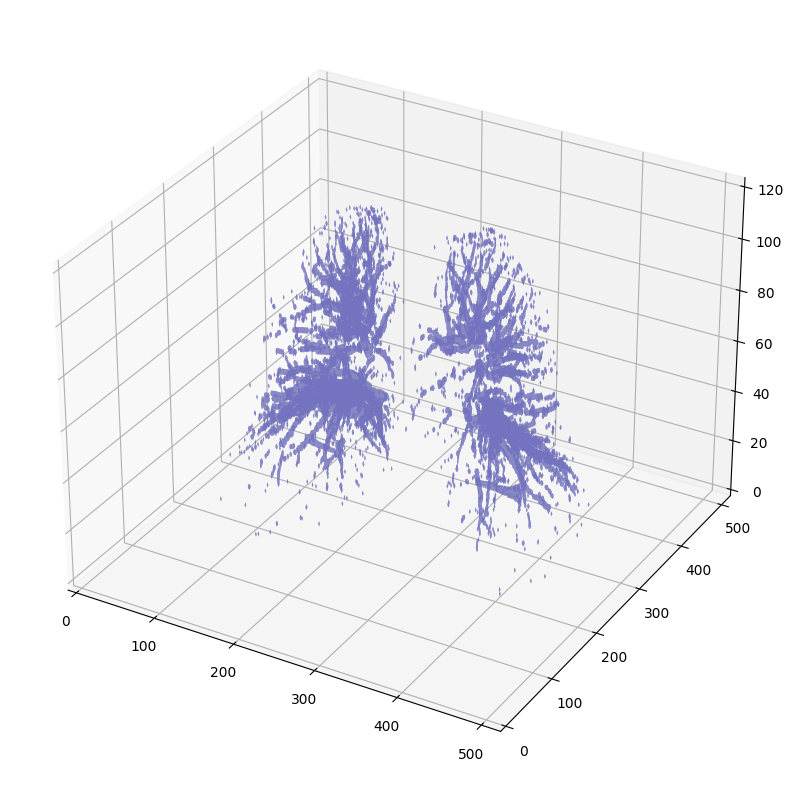

In [48]:
plot_3d(segmented_lungs_fill - segmented_lungs, threshold=0)

In [49]:
# Load the annotations CSV
df_annotations = pd.read_csv('/kaggle/input/luna16/annotations.csv')

# Helper to extract the series UID from the mhd filename
def get_series_uid(mhd_path):
    basename = os.path.basename(mhd_path)
    seriesuid = os.path.splitext(basename)[0]
    return seriesuid

# Define a helper function to convert world coordinates to voxel coordinates.
def world_to_voxel(world_coords, origin, spacing):
    """
    Convert world coordinates (x,y,z) in mm to voxel coordinates (x,y,z).
    """
    voxel_coords = np.round((world_coords - origin) / spacing).astype(int)
    return voxel_coords

def plot_nodules_3d(image, annotations, origin, spacing, seriesuid, threshold=-300):
    """
    Visualize a 3D CT scan with pulmonary nodules overlaid.
    
    Parameters:
      - image: 3D numpy array (shape: [z, y, x]) representing the CT scan.
      - annotations: DataFrame with nodule annotations.
      - origin: The CT scan origin (x, y, z) in mm.
      - spacing: The voxel spacing (x, y, z) in mm (should be [1,1,1] after resampling).
      - seriesuid: String identifier for the CT scan series.
      - threshold: Intensity threshold for surface extraction.
    """
    # Filter annotations for the current series.
    nodule_df = annotations[annotations['seriesuid'] == seriesuid]
    
    # Create the 3D surface (we use the same approach as in plot_3d)
    p = image.transpose(2, 1, 0)  # reorient to (x, y, z)
    verts, faces, _, _ = measure.marching_cubes(p, level=threshold)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    mesh.set_facecolor([0.45, 0.45, 0.75])
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    # For each annotated nodule, convert its world coordinates to voxel coordinates and overlay on the plot.
    for idx, row in nodule_df.iterrows():
        world_coords = np.array([row['coordX'], row['coordY'], row['coordZ']])
        voxel_coords = world_to_voxel(world_coords, origin, spacing)  # (x,y,z) coordinates
        ax.scatter(voxel_coords[0], voxel_coords[1], voxel_coords[2],
                   color='red', s=50, label='Nodule' if idx == 0 else "")
    
    plt.title("3D CT Scan with Pulmonary Nodules")
    plt.legend()
    plt.show()

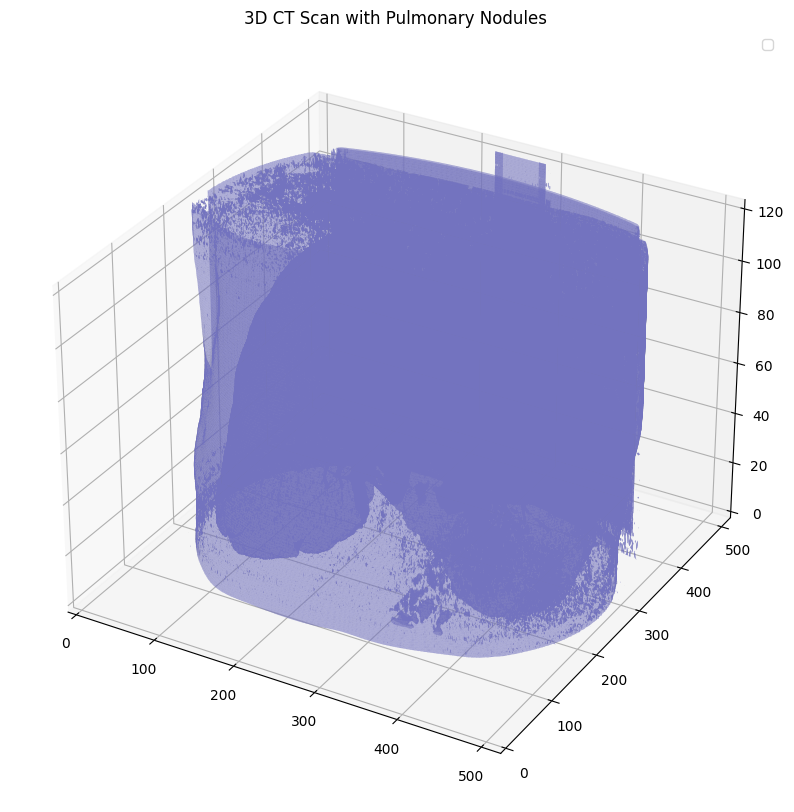

In [50]:
# Extract the series UID from the mhd filename.
seriesuid = get_series_uid(mhd_file)

# Visualize the nodules on the 3D CT scan.
# Here, resampled_pixels is our resampled CT scan (3D numpy array),
# origin and new_spacing ([1,1,1]) are used to convert annotation coordinates.
plot_nodules_3d(resampled_pixels, df_annotations, origin, new_spacing, seriesuid, threshold=-300)

Pretty cool, no? 

Anyway, when you want to use this mask, **remember to first apply a dilation morphological operation** on it (i.e. with a circular kernel).  This expands the mask in all directions. The air + structures in the lung alone will not contain all nodules, in particular it will miss those that are stuck to the side of the lung, where they often appear! So expand the mask a little :)

**This segmentation may fail for some edge cases**. It relies on the fact that the air outside the patient is not connected to the air in the lungs. If the patient has a [tracheostomy](https://en.wikipedia.org/wiki/Tracheotomy), this will not be the case, I do not know whether this is present in the dataset. Also, particulary noisy images (for instance due to a pacemaker in the image below) this method may also fail. Instead, the second largest air pocket in the body will be segmented. You can recognize this by checking the fraction of image that the mask corresponds to, which will be very small for this case. You can then first apply a morphological closing operation with a kernel a few mm in size to close these holes, after which it should work (or more simply, do not use the mask for this image). 

![pacemaker example][1]

# Normalization
Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity.  A commonly used set of thresholds in the LUNA16 competition to normalize between are -1000 and 400. Here's some code you can use:


  [1]: http://i.imgur.com/po0eX1L.png

In [51]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

# Zero centering

As a final preprocessing step, it is advisory to zero center your data so that your mean value is 0. To do this you simply subtract the mean pixel value from all pixels. 

To determine this mean you simply average all images in the whole dataset.  If that sounds like a lot of work, we found this to be around 0.25 in the LUNA16 competition. 

**Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures.**

In [53]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

# Understand the Dataset


In [54]:
df_annotations = pd.read_csv('/kaggle/input/luna16/annotations.csv')
df_annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [55]:
df_annotations.shape


(1186, 5)

There are 1,186 total annotations available.

Candidates
The candidates file contains a class flag for each mass in the CT scans.

seriesuid is the unique identifer of the CT scan.

coordX, coordY and coordZ are coorindates of the center of the mass.

class is 0 if the mass isn't a nodule, and 1 if it is a nodule (both malignant and benign).

In [57]:
df_candidates = pd.read_csv('/kaggle/input/luna16/candidates_V2/candidates_V2.csv')
df_candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,0


In [58]:
df_candidates.shape


(754975, 5)

There are over 750k candidates.

The huge difference between candidates and annotations tells us that we will have many candidates for which we won't have a diameter in the annotations file. However, if fine for now as we won't be using the diameter information when building this simple model.

Another thing to note is that there can be multiple annotations and candidates in a single CT scan.

In [59]:
print(f'Total annotations: {df_annotations.shape[0]}, Unique CT scans: {len(df_annotations.seriesuid.unique())}')
print(f'Total candidates: {df_candidates.shape[0]}, Unique CT scans: {len(df_candidates.seriesuid.unique())}')

Total annotations: 1186, Unique CT scans: 601
Total candidates: 754975, Unique CT scans: 888
